<a href="https://colab.research.google.com/github/fjamshidi80/CameraCalibration/blob/main/ClassificationGoodBadCropFlow_10_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import time


from sklearn.model_selection import train_test_split
from PIL import Image, UnidentifiedImageError
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
)

from tensorflow.keras.models import Sequential,save_model, load_model
from tensorflow.keras.layers import Dense

# Install the PyDrive library if not already installed
# !pip install PyDrive

# Import necessary modules for Google Drive integration
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from google.colab import files, drive


In [ ]:
width,height,length=338,150,150
target_size = (width, length)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to the folder containing subfolders
extracted_folder = '/content/drive/MyDrive/CropFlowImages2Class'

# Initialize a dictionary to store the count of images per folder
image_counts = {}

# Iterate through subfolders in the extracted_folder
for subfolder in os.listdir(extracted_folder):
    subfolder_path = os.path.join(extracted_folder, subfolder)

    # Check if the subfolder is a directory
    if os.path.isdir(subfolder_path):
        # Count the number of image files (files with common image extensions)
        image_count = len([file for file in os.listdir(subfolder_path) if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))])
        image_counts[subfolder] = image_count

# Print the image counts per folder
for folder, count in image_counts.items():
    print(f"{folder}: {count} images")
class_names = sorted([subfolder for subfolder in os.listdir(extracted_folder) if os.path.isdir(os.path.join(extracted_folder, subfolder))])

Bad: 1104 images
Good: 1956 images


**Not This**

In [ ]:


def read_images(extracted_folder, target_size):#, test_size=0.2, validation_size=0.2):
    root_folder = sorted([subfolder for subfolder in os.listdir(extracted_folder) if os.path.isdir(os.path.join(extracted_folder, subfolder))])


    images = []
    labels = []
    Filenames = []

    for class_idx, subfolder in enumerate(root_folder):
        class_folder = os.path.join(extracted_folder, subfolder)

        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            try:
                img = Image.open(img_path)
                if os.path.isfile(img_path):
                    img = img.convert('L')
                    img = img.resize(target_size)
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(class_idx)
                    Filenames.append(filename)
            except (UnidentifiedImageError, OSError):
                print(f"Could not open image: {img_path}. Skipping...")
                continue
    images = np.array(images) / 255.0
    labels=np.array(labels)
    return images,labels, Filenames


**Standardization, which scales pixel values to have a mean of 0 and a standard deviation of 1. This is useful when dealing with images with varying brightness and contrast.**

In [ ]:
def read_images(extracted_folder, target_size):#, test_size=0.2, validation_size=0.2):
    root_folder = sorted([subfolder for subfolder in os.listdir(extracted_folder) if os.path.isdir(os.path.join(extracted_folder, subfolder))])


    images = []
    labels = []
    Filenames = []

    for class_idx, subfolder in enumerate(root_folder):
        class_folder = os.path.join(extracted_folder, subfolder)

        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            try:
                img = Image.open(img_path)
                if os.path.isfile(img_path):
                    img = img.convert('L')
                    img = img.resize(target_size)
                    img_array = np.array(img)
                    mean = np.mean(img_array)
                    std = np.std(img_array)
                    normalized_image = (img_array - mean) / std
                    images.append(normalized_image)
                    labels.append(class_idx)
                    Filenames.append(filename)
            except (UnidentifiedImageError, OSError):
                print(f"Could not open image: {img_path}. Skipping...")
                continue
    images = np.array(images)# / 255.0
    labels=np.array(labels)
    return images,labels, Filenames


In [ ]:
target_size = (width, length)
images,labels, Filenames=read_images(extracted_folder, target_size)

In [ ]:
# Assuming you have a NumPy array 'labels' containing class labels (shape: (718,))
# Find unique class labels in 'labels' array
unique_classes = np.unique(labels)

# Count the number of unique classes
num_classes = len(unique_classes)

In [ ]:
# model...
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(width,length,1)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
#model.add(layers.Dense(64, activation='relu'))
##'sigmoid' 'tanh' 'linear' 'elu'
##'tf.keras.layers.LeakyReLU(alpha=0.2)
## tf.keras.layers.PReLU()
## tf.keras.layers.Swish()
model.add(layers.Dense(64, activation='sigmoid'))
#model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(num_classes, activation='softmax'))
print(model.summary())
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 336, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 168, 74, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 166, 72, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 83, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 95616)             0         
                                                                 
 dropout (Dropout)           (None, 95616)             0

In [ ]:
# Loads the weights
checkpoint_path = "/content/drive/MyDrive/training_2/cp.ckpt"
model.load_weights(checkpoint_path)

**K fold Without saving results**

In [ ]:
# Shuffle the data (assuming 'images' and 'labels' are NumPy arrays)
shuffled_indices = np.random.permutation(len(images))
shuffled_images = images[shuffled_indices]
shuffled_labels = labels[shuffled_indices]

# Define the number of folds (k)
k = 5

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Initialize StratifiedKFold for splitting data while preserving class distribution
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Split the shuffled data into training, validation, and test sets
train_ratio = 0.7  # Example ratio: 60% training, 20% validation, 20% test
val_ratio = 0.15
test_ratio = 0.15
num_epochs, batch_size=2,8
train_images, test_images, train_labels, test_labels = train_test_split(
    shuffled_images, shuffled_labels, test_size=test_ratio, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=val_ratio / (1 - test_ratio), random_state=42)
test_images = test_images.reshape(-1, width, length, 1)
# Perform k-fold cross-validation on the training and validation sets
for train_index, val_index in kf.split(train_images, train_labels):
    train_fold_images, val_fold_images = train_images[train_index], train_images[val_index]
    train_fold_labels, val_fold_labels = train_labels[train_index], train_labels[val_index]
    train_fold_images = train_fold_images.reshape(-1, width, length, 1)
    val_fold_images = val_fold_images.reshape(-1, width, length, 1)

    # Compile and train your model on the training set (train_fold_images, train_fold_labels)

    model.fit(train_fold_images, train_fold_labels, epochs=num_epochs, batch_size=batch_size, verbose=1,validation_data=(val_fold_images, val_fold_labels))
    print("---------------------")
    # Evaluate your model on the validation set (val_fold_images, val_fold_labels)
    # Assuming you have predicted labels for the test data
    test_predicted_labels = model.predict(test_images)
    test_predicted_labels = np.argmax(test_predicted_labels, axis=1)

# Calculate metrics
    # Calculate metrics with zero_division parameter set to 'warn'
    accuracy = accuracy_score(test_labels, test_predicted_labels)
    precision = precision_score(test_labels, test_predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(test_labels, test_predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(test_labels, test_predicted_labels, average='weighted', zero_division=0)

    # Calculate and collect other metrics like precision, recall, F1-score
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
# Calculate average metrics over all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)


# Print or store the test set metrics
print(f'Test Evaluation: ')
# Print or store other test metrics if needed

# Print or store the average metrics for training, validation, and test sets
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average precision: {avg_precision}')
print(f'Average recall: {avg_recall}')
print(f'Average f1: {avg_f1}')
# Print or store other average metrics if needed


**K fold that is saved**

In [ ]:
# Shuffle the data (assuming 'images' and 'labels' are NumPy arrays)
shuffled_indices = np.random.permutation(len(images))
shuffled_images = images[shuffled_indices]
shuffled_labels = labels[shuffled_indices]



# Define the number of folds (k)
k = 5

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Initialize StratifiedKFold for splitting data while preserving class distribution
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Split the shuffled data into training, validation, and test sets
train_ratio = 0.7  # Example ratio: 60% training, 20% validation, 20% test
val_ratio = 0.15
test_ratio = 0.15
num_epochs, batch_size=2,8
train_images, test_images, train_labels, test_labels = train_test_split(
    shuffled_images, shuffled_labels, test_size=test_ratio, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=val_ratio / (1 - test_ratio), random_state=42)
test_images = test_images.reshape(-1, width, length, 1)
# Perform k-fold cross-validation on the training and validation sets
for train_index, val_index in kf.split(train_images, train_labels):
    train_fold_images, val_fold_images = train_images[train_index], train_images[val_index]
    train_fold_labels, val_fold_labels = train_labels[train_index], train_labels[val_index]
    train_fold_images = train_fold_images.reshape(-1, width, length, 1)
    val_fold_images = val_fold_images.reshape(-1, width, length, 1)
    model.fit(train_fold_images, train_fold_labels, epochs=num_epochs, batch_size=batch_size, verbose=1,validation_data=(val_fold_images, val_fold_labels),callbacks=[cp_callback])
    #model.fit(train_images, train_labels, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(val_images, val_labels),callbacks=[cp_callback])
    print("---------------------")
    # Evaluate your model on the validation set (val_fold_images, val_fold_labels)
    # Assuming you have predicted labels for the test data
    test_predicted_labels = model.predict(test_images)
    test_predicted_labels = np.argmax(test_predicted_labels, axis=1)

# Calculate metrics
    # Calculate metrics with zero_division parameter set to 'warn'
    accuracy = accuracy_score(test_labels, test_predicted_labels)
    precision = precision_score(test_labels, test_predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(test_labels, test_predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(test_labels, test_predicted_labels, average='weighted', zero_division=0)

    # Calculate and collect other metrics like precision, recall, F1-score
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
# Calculate average metrics over all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)


# Print or store the test set metrics
print(f'Test Evaluation: ')
# Print or store other test metrics if needed

# Print or store the average metrics for training, validation, and test sets
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average precision: {avg_precision}')
print(f'Average recall: {avg_recall}')
print(f'Average f1: {avg_f1}')
# Print or store other average metrics if needed


NameError: ignored

In [ ]:
# Shuffle the data (assuming 'images' and 'labels' are NumPy arrays)
shuffled_indices = np.random.permutation(len(images))
shuffled_images = images[shuffled_indices]
shuffled_labels = labels[shuffled_indices]

# Define the split ratios
train_ratio = 0.7  # Example ratio: 70% training
val_ratio = 0.15   # Example ratio: 15% validation
test_ratio = 0.15  # Example ratio: 15% test
num_epochs, batch_size=10,8
# Split the shuffled data into training, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    shuffled_images, shuffled_labels, test_size=test_ratio, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=val_ratio / (1 - test_ratio), random_state=42)

test_images = test_images.reshape(-1, width, length, 1)
train_images = train_images.reshape(-1, width, length, 1)
val_images = val_images.reshape(-1, width, length, 1)
# Compile and train your model on the training set (train_images, train_labels)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
num_epochs, batch_size=10,8
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(train_images, train_labels, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(val_images, val_labels),callbacks=[cp_callback])

Epoch 1/10
268/268 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9972
Epoch 1: saving model to /content/drive/MyDrive/training_2/cp.ckpt
268/268 [==============================] - 159s 595ms/step - loss: 0.0136 - accuracy: 0.9972 - val_loss: 0.0218 - val_accuracy: 0.9957
Epoch 2/10
268/268 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9939
Epoch 2: saving model to /content/drive/MyDrive/training_2/cp.ckpt
268/268 [==============================] - 159s 594ms/step - loss: 0.0178 - accuracy: 0.9939 - val_loss: 0.0130 - val_accuracy: 0.9978
Epoch 3/10
268/268 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9977
Epoch 3: saving model to /content/drive/MyDrive/training_2/cp.ckpt
268/268 [==============================] - 158s 589ms/step - loss: 0.0106 - accuracy: 0.9977 - val_loss: 0.0148 - val_accuracy: 0.9978
Epoch 4/10
268/268 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9944
Epoch 4: s

In [ ]:
# Loads the weights
checkpoint_path = "/content/drive/MyDrive/training_2/cp.ckpt"
model.load_weights(checkpoint_path)

In [ ]:

# Evaluate your model on the test set (test_images, test_labels)
# Assuming you have predicted labels for the test data
test_predicted_labels = model.predict(test_images)
test_predicted_labels = np.argmax(test_predicted_labels, axis=1)

# Calculate metrics
# Calculate metrics with zero_division parameter set to 'warn'
accuracy = accuracy_score(test_labels, test_predicted_labels)
precision = precision_score(test_labels, test_predicted_labels, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(test_labels, test_predicted_labels, average='weighted', zero_division=0)

# Print or store the test set metrics
print(f'Test Evaluation: ')
# Print or store other test metrics if needed

# Print or store the metrics for the single training-validation split
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
# Print or store other metrics if needed

15/15 [==============================] - 9s 591ms/step
Test Evaluation: 
Accuracy: 0.9978213507625272
Precision: 0.9978343965663444
Recall: 0.9978213507625272
F1-score: 0.9978227599142632


In [ ]:
class_counts = {}
# Loop through each unique class and count the occurrences
for class_label in unique_classes:
    class_count = np.sum(labels == class_label)
    class_counts[class_label] = class_count

# Print the count of images in each class
for class_label, count in class_counts.items():
    print(f"For Data set Class {class_label}: {count} images")
class_counts = {}
# Loop through each unique class and count the occurrences
for class_label in unique_classes:
    class_count = np.sum(train_labels == class_label)
    class_counts[class_label] = class_count

# Print the count of images in each class
for class_label, count in class_counts.items():
    print(f"For Train set Class {class_label}: {count} images")
class_counts = {}
# Loop through each unique class and count the occurrences
for class_label in unique_classes:
    class_count = np.sum(test_labels == class_label)
    class_counts[class_label] = class_count

# Print the count of images in each class
for class_label, count in class_counts.items():
    print(f"For Test set Class {class_label}: {count} images")
class_counts = {}
# Loop through each unique class and count the occurrences
for class_label in unique_classes:
    class_count = np.sum(val_labels == class_label)
    class_counts[class_label] = class_count

# Print the count of images in each class
for class_label, count in class_counts.items():
    print(f"For Validation set Class {class_label}: {count} images")

For Data set Class 0: 1104 images
For Data set Class 1: 1956 images
For Train set Class 0: 779 images
For Train set Class 1: 1362 images
For Test set Class 0: 166 images
For Test set Class 1: 293 images
For Validation set Class 0: 159 images
For Validation set Class 1: 301 images


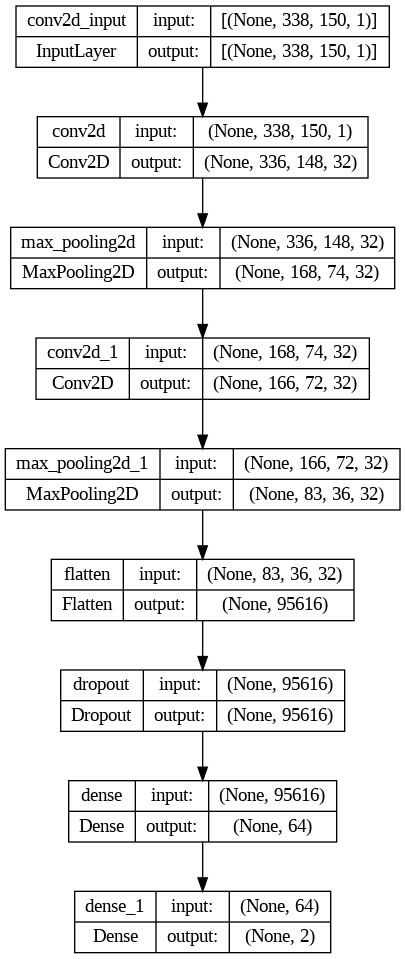

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot the model architecture
plt.figure(figsize=(10, 6))
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Assuming you have predicted labels for the test data
test_predicted_labels = model.predict(test_images)
test_predicted_labels = np.argmax(test_predicted_labels, axis=1)

# Calculate metrics
accuracy = accuracy_score(test_labels, test_predicted_labels)
precision = precision_score(test_labels, test_predicted_labels, average='weighted')
recall = recall_score(test_labels, test_predicted_labels, average='weighted')
f1 = f1_score(test_labels, test_predicted_labels, average='weighted')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Classification report
print("Classification Report:\n", classification_report(test_labels, test_predicted_labels))

# Confusion matrix
cm = confusion_matrix(test_labels, test_predicted_labels)
#print("Confusion Matrix:\n", cm)

15/15 [==============================] - 7s 479ms/step
Accuracy: 0.9978213507625272
Precision: 0.9978343965663444
Recall: 0.9978213507625272
F1 Score: 0.9978227599142632
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       166
           1       1.00      1.00      1.00       293

    accuracy                           1.00       459
   macro avg       1.00      1.00      1.00       459
weighted avg       1.00      1.00      1.00       459



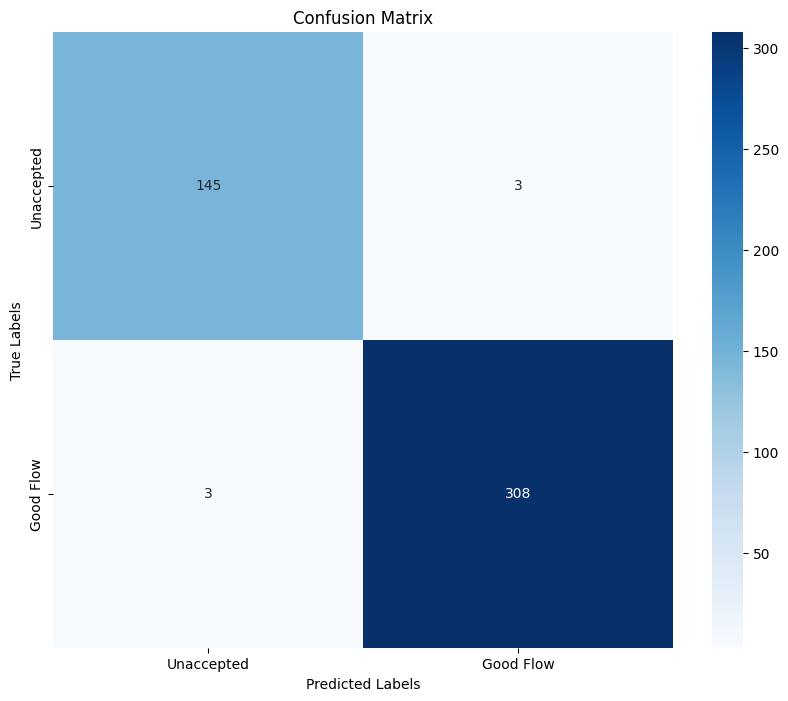

In [ ]:
# Plot confusion matrix
class_names = ['Unaccepted', 'Good Flow']
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()